In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np

from fastdtw import fastdtw

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import matplotlib.pyplot as plt

import rasterio
from osgeo import gdal, ogr, osr
from gdalconst import *
gdal.UseExceptions()

from datetime import datetime

import stac

## Demostração da necessidade da janela móvel

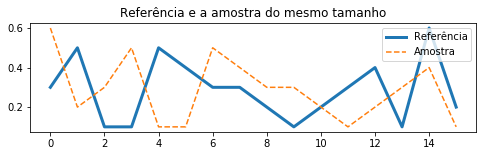

In [2]:
ref =    [0.3, 0.5, 0.1, 0.1, 0.5, 0.4, 0.3, 0.3, 0.2, 0.1, 0.2, 0.3, 0.4, 0.1, 0.6, 0.2]
sample = [0.6, 0.2, 0.3, 0.5, 0.1, 0.1, 0.5, 0.4, 0.3, 0.3, 0.2, 0.1, 0.2, 0.3, 0.4, 0.1]

fig, ax = plt.subplots(1,1, figsize=(8,2))

ax.plot(ref, lw=3, label='Referência')
ax.plot(sample, ls='--', label='Amostra')
ax.legend()
ax.set_title('Referência e a amostra do mesmo tamanho');


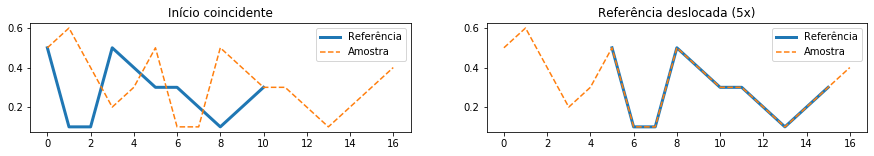

In [3]:
ref =    [0.5, 0.1, 0.1, 0.5, 0.4, 0.3, 0.3, 0.2, 0.1, 0.2, 0.3]
ref_deslocada = np.array([np.nan, np.nan, np.nan, np.nan, np.nan, 0.5, 0.1, 0.1, 0.5, 0.4, 0.3, 0.3, 0.2, 0.1, 0.2, 0.3])
sample = [0.5, 0.6, 0.4, 0.2, 0.3, 0.5, 0.1, 0.1, 0.5, 0.4, 0.3, 0.3, 0.2, 0.1, 0.2, 0.3, 0.4]

fig, ax = plt.subplots(1,2, figsize=(15,2))

ax[0].plot(ref, lw=3, label='Referência')
ax[0].plot(sample, ls='--', label='Amostra')
ax[0].legend()
ax[0].set_title('Início coincidente')

ax[1].plot(ref_deslocada, lw=3, label='Referência')
ax[1].plot(sample, ls='--', label='Amostra')
ax[1].set_title('Referência deslocada (5x)')
ax[1].legend();


#### Janela móvel

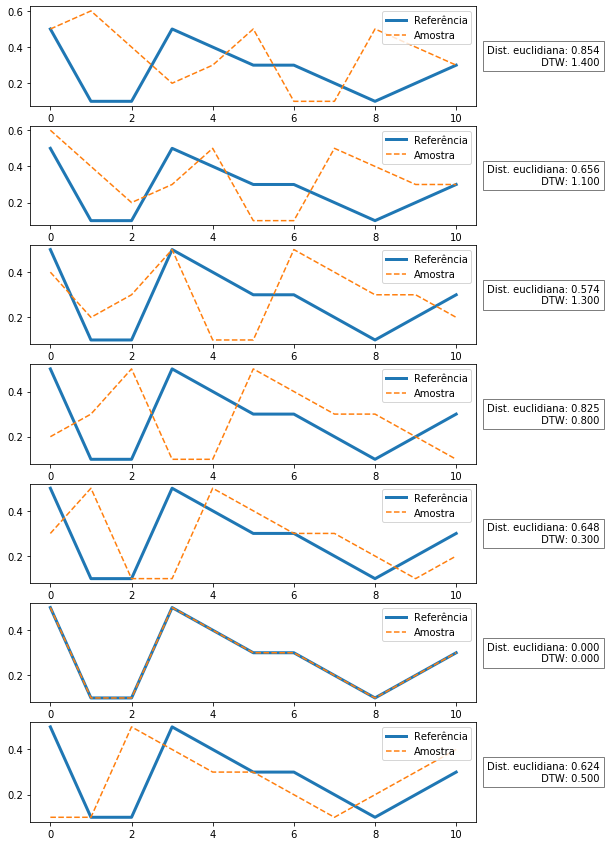

In [4]:
fig, ax = plt.subplots((len(sample)-len(ref)+1), 1, figsize=(8,15))

# Janela móvel de análise
for i in range(len(sample)-len(ref)+1):
    
    sample_part = sample[i:i+len(ref)]
    
    euclidean_distance = np.linalg.norm(np.array(ref) - np.array(sample_part))
    dtw_distance, dtw_path = fastdtw(ref, sample_part)
    text = 'Dist. euclidiana: {:05.3f}'.format(euclidean_distance) + '\n' + '{:>27}'.format('DTW: ' + '{:05.3f}'.format(dtw_distance))
    
    ax[i].plot(ref, label='Referência',lw=3)
    ax[i].plot(sample_part, label='Amostra',ls='--')
    ax[i].text(1.15, 0.5, text, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, bbox=dict(facecolor='white', alpha=0.5))   
    ax[i].legend()

___

## Análise

In [3]:
references = pd.DataFrame(np.load('./DADOS/references.npy', allow_pickle=True))
dict_values_df = np.load('./DADOS/dict_test.npy', allow_pickle=True).item()

In [7]:
final_result = {}
# Para cada ano agricola
for ano in dict_values_df.keys():
    
    result_points = {}
    # Para cada ponto
    for ponto in dict_values_df[ano].columns:
        
        sample = list(dict_values_df[ano].loc[:,ponto])
        
        result = False
        
        # Para cada referencia
        for n in references:
            if result:
                break
                
            else:
                ref = list(references[n])
                
                # janela móvel
                i = 0
                while i < len(sample)-len(ref)+1 and not result:

                    sample_part = sample[i:i+len(ref)]

                    euclidean_distance = np.linalg.norm(np.array(ref) - np.array(sample_part))
#                     dtw_distance, dtw_path = fastdtw(ref, sample_part)

                    if euclidean_distance < 0.5:
                        result = True
                                           
                    i += 1
                result_points[ponto] = result
            
        final_result[ano] = result_points

In [ ]:
np.save('./DADOS/classif.npy', pd.DataFrame(final_result))

### Resultado

In [ ]:
from IPython.display import display

pd.options.display.max_rows = 500

display(pd.DataFrame(final_result))